In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

In [22]:
# data_dir = '/Users/mik/Desktop/bubble_files/data/wrench_calibration_data/medusa_wrench_zero_tool'
data_dir = '/Users/mik/Desktop/bubble_files/data/wrench_calibration_data/medusa_wrench_no_tool_calibrated'
save_dir = '/Users/mik/Desktop'

In [23]:
data_dir_name = data_dir.split('/')[-1]
dl_path = os.path.join(data_dir, '{}_DataLegend.csv'.format(data_dir_name))

data_legend = pd.read_csv(dl_path)

In [24]:
data_legend

,Time,Sequence,SequenceIndx,FileCode,JointState
0,1.633965e+09,0,0,1,"(-0.5245831398783436, 0.6259654880742292, -0.0..."
1,1.633965e+09,0,1,2,"(-0.5238833809852677, 0.4906279357772146, -0.0..."
2,1.633965e+09,0,2,3,"(-0.5458994207916897, 0.38732445644068597, -0...."
3,1.633965e+09,0,3,4,"(-0.42696473711321636, 0.7945409285487697, -0...."
4,1.633965e+09,0,4,5,"(-0.44689414351459494, 0.6763287138785161, -0...."
...,...,...,...,...,...
589,1.633967e+09,10,49,590,"(-0.44687658670223374, 0.6764394481473213, -0...."
590,1.633967e+09,10,50,591,"(-0.42680858261412347, 0.7945494373561224, -0...."
591,1.633967e+09,10,51,592,"(-0.545753992213515, 0.38717195720646214, -0.0..."
592,1.633967e+09,10,52,593,"(-0.5240199412182638, 0.4906392608914815, -0.0..."


In [25]:
def load_wrench(fc, scene_name):
    wrench_dir = os.path.join(data_dir, scene_name, 'wrenches')
    wrench_file_path = os.path.join(wrench_dir, '{}_wrench_{:06}.csv'.format(scene_name, fc))
    wrench_df = pd.read_csv(wrench_file_path)
    return wrench_df

def load_tfs(fc, scene_name):
    tfs_dir = os.path.join(data_dir, scene_name, 'tfs')
    tfs_file_path = os.path.join(tfs_dir, 'recorded_tfs_{:06}.csv'.format(fc))
    tfs_df = pd.read_csv(tfs_file_path)
    return tfs_df

In [26]:
load_wrench(1, 'wrench_scene')

,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,wrench.force.x,wrench.force.y,wrench.force.z,wrench.torque.x,wrench.torque.y,wrench.torque.z
0,1427697,1633964859,398370981,med_kuka_link_ee,-1.467385,0.638770,-0.142249,-0.038170,0.351663,0.378375
1,0,1633964859,398370981,grasp_frame,-0.638765,-1.467387,-0.142249,-0.351663,-0.038171,0.378375
2,0,1633964859,398370981,med_base,1.477657,0.615759,0.137302,0.044036,0.347719,-0.381371


In [27]:
load_tfs(4,'wrench_scene')

,Unnamed: 0,parent_frame,child_frame,x,y,z,qx,qy,qz,qw


In [28]:
def load_data(ref_frame='med_kuka_link_ee'):
    filecodes = data_legend['FileCode']
    scene_name = 'wrench_scene'
    all_data = []
    tfs_columns = ['parent_frame', 'child_frame', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']
    wrench_columns = ['wrench.force.x', 'wrench.force.y', 'wrench.force.z', 'wrench.torque.x', 'wrench.torque.y', 'wrench.torque.z']
    data_columns = ['fc'] + tfs_columns + wrench_columns 
    for i, fc in enumerate(tqdm(filecodes)):
        sequence_i = data_legend['Sequence'][i]
        sequence_indx_i = data_legend['SequenceIndx'][i]
        time_i = data_legend['Time'][i]
        wrenches_i = load_wrench(fc, scene_name)
        tfs_i = load_tfs(fc, scene_name)
        tf_i = tfs_i.loc[tfs_i['child_frame'] == ref_frame]
        wrench_i = wrenches_i.loc[wrenches_i['header.frame_id'] == ref_frame]
        tf_data_i = tf_i[tfs_columns].reset_index(drop=True)
        wrench_data_i = wrench_i[wrench_columns].reset_index(drop=True)
#         import pdb; pdb.set_trace()
        data_i = pd.concat([tf_data_i,wrench_data_i],axis=1)
        data_i['FileCode'] = fc
        data_i['Sequence'] = sequence_i
        data_i['SequenceIndx'] = sequence_indx_i
        data_i['Time'] = time_i
        all_data.append(data_i)
    df = pd.concat(all_data, ignore_index=True)
    wrapped_indxs = df['SequenceIndx'] % (27*2)
    mask = wrapped_indxs//27
    df['PositionIndx'] = wrapped_indxs * ((-1)*(mask-1)) + mask*(27*2-1-wrapped_indxs)
    return df
        
        
        
    

In [29]:
all_data = load_data()

100%|██████████| 594/594 [00:05<00:00, 104.47it/s]


In [30]:
test_grid = np.array(np.meshgrid([0,1,2], [0,1,2], [0,1,2])).T.reshape(-1,3)
test_grid.shape

(27, 3)

In [31]:
xyz_indx_grid = test_grid[:,[0,2,1]]
xyz_indx_grid_reversed = np.flip(xyz_indx_grid, axis=0)
xyz_indxs = np.concatenate([xyz_indx_grid, xyz_indx_grid_reversed])

In [32]:
all_data.SequenceIndx

0       0
1       1
2       2
3       3
4       4
       ..
589    49
590    50
591    51
592    52
593    53
Name: SequenceIndx, Length: 594, dtype: int64

In [33]:
# add indexes so we know the point it is
all_data['x_indx'] = 0
all_data['y_indx'] = 0
all_data['z_indx'] = 0
all_data['x_val'] = 0
all_data['y_val'] = 0
all_data['z_val'] = 0

In [34]:
all_data['x_indx'] = xyz_indxs[all_data['SequenceIndx'],0]
all_data['y_indx'] = xyz_indxs[all_data['SequenceIndx'],1]
all_data['z_indx'] = xyz_indxs[all_data['SequenceIndx'],2]

In [35]:
all_data.loc[all_data.x_indx == 0, 'x_val'] = .45
all_data.loc[all_data.x_indx == 1, 'x_val'] = .55
all_data.loc[all_data.x_indx == 2, 'x_val'] = .65
all_data.loc[all_data.y_indx == 0, 'y_val'] = -.3
all_data.loc[all_data.y_indx == 1, 'y_val'] = 0
all_data.loc[all_data.y_indx == 2, 'y_val'] = .3
all_data.loc[all_data.z_indx == 0, 'z_val'] = .3
all_data.loc[all_data.z_indx == 1, 'z_val'] = .4
all_data.loc[all_data.z_indx == 2, 'z_val'] = .5

In [36]:
all_data['PositionIndx'] = all_data.z_indx + 3*all_data.x_indx + 9*all_data.y_indx

<ipython-input-37-50834b410d89>:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-37-50834b410d89>:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-37-50834b410d89>:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-37-50834b410d89>:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-37-50834b

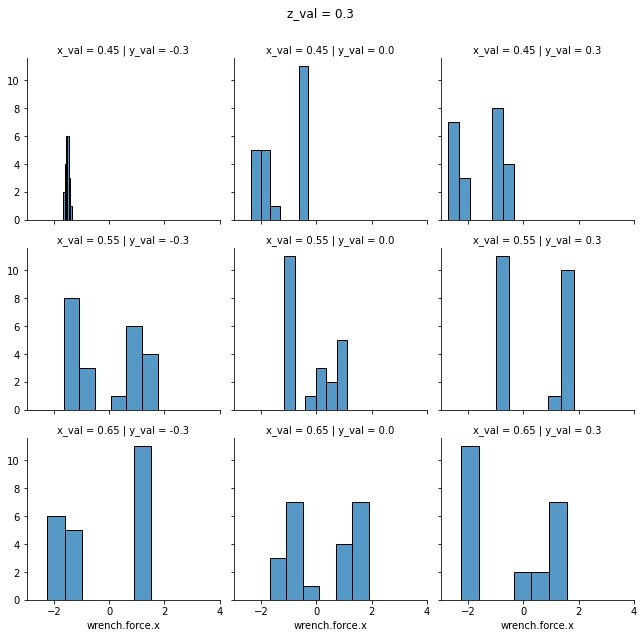

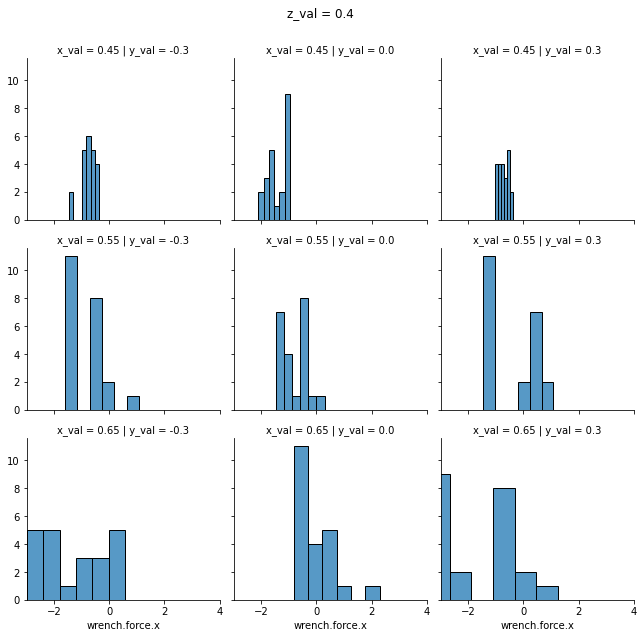

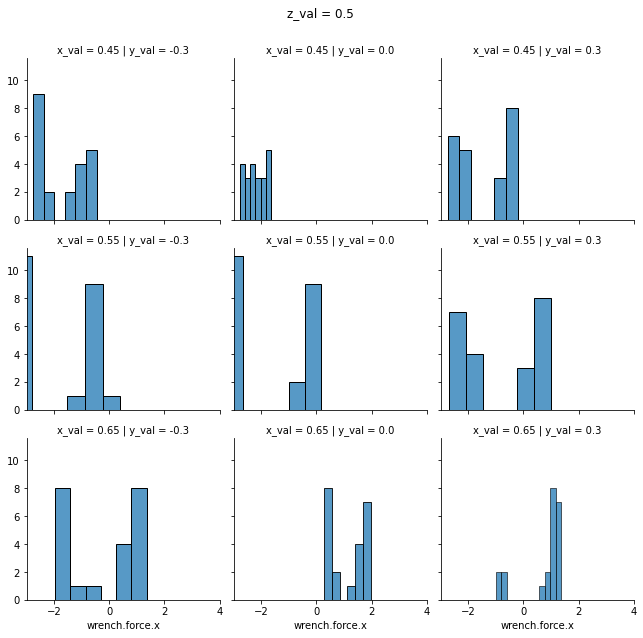

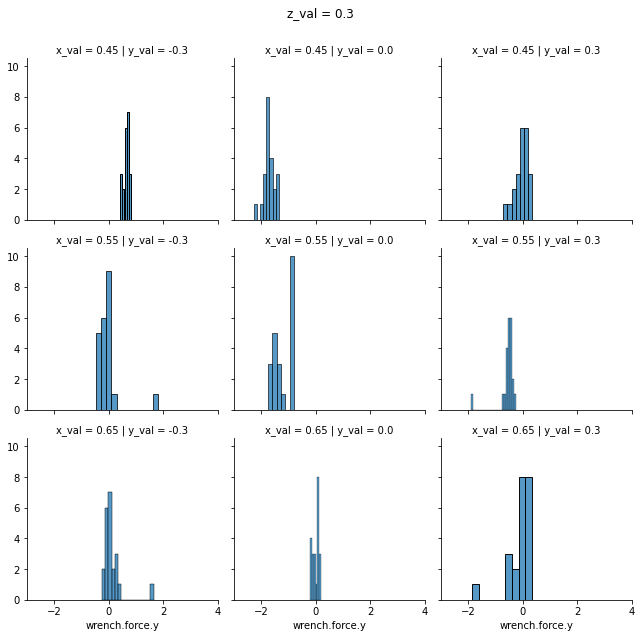

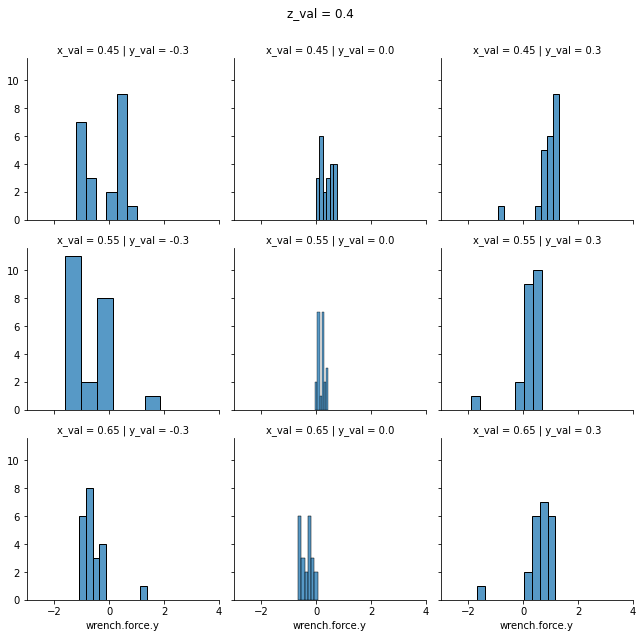

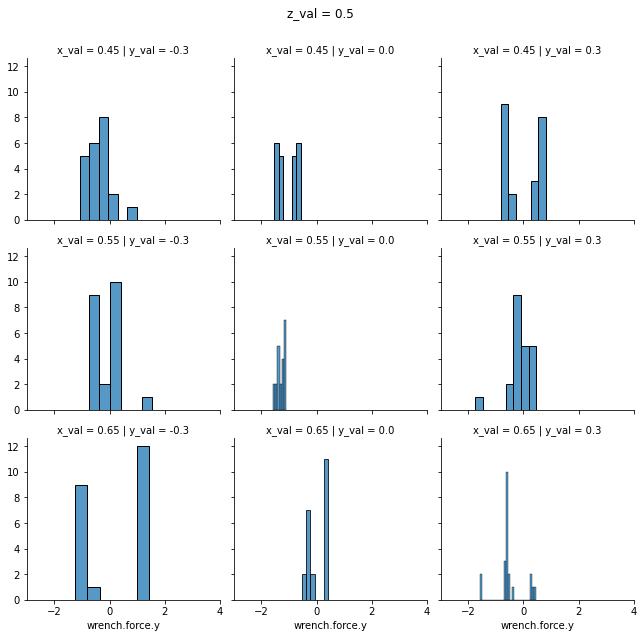

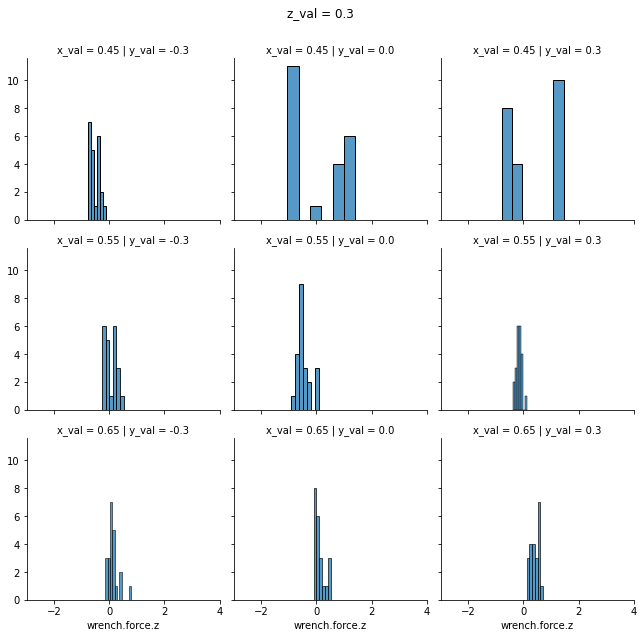

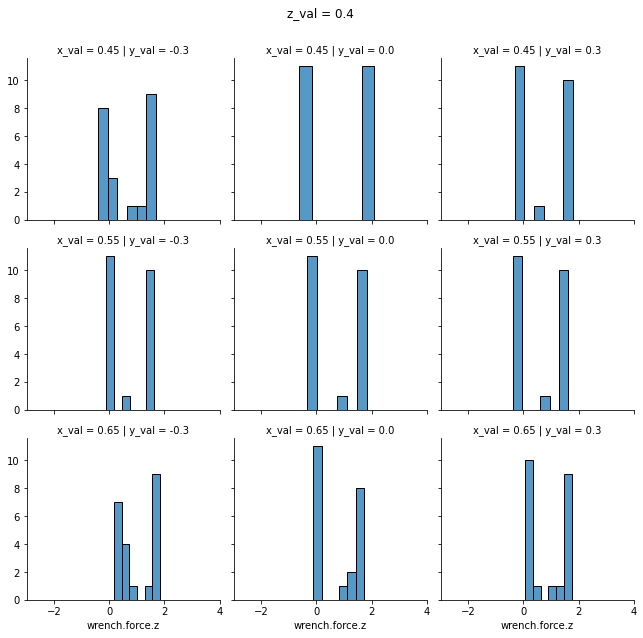

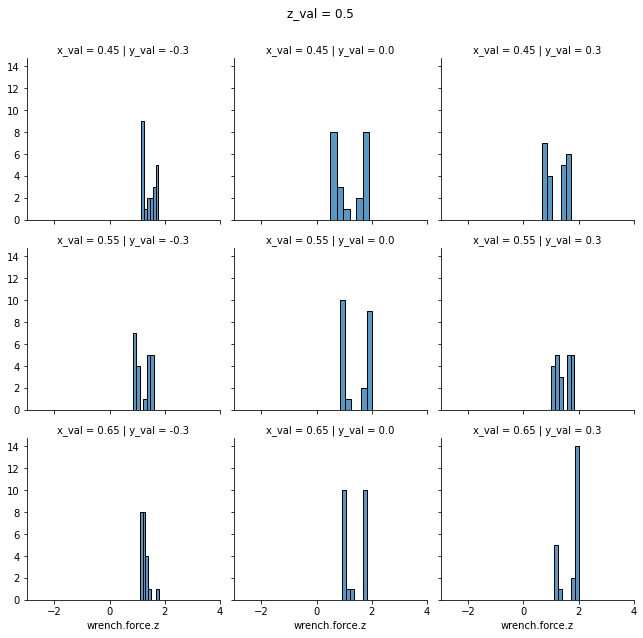

In [37]:

topic_names = ['wrench.force.x', 'wrench.force.y', 'wrench.force.z']
for topic_name in topic_names:
    z_vals = np.unique(all_data.z_val)
    imgs = []
    for i, z_val in enumerate(z_vals):
        g = sns.FacetGrid(all_data[all_data.z_val == z_val], col='y_val', row='x_val')
        g.map(sns.histplot, topic_name)
        g.set(xlim=(-3, 4))
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle('z_val = {}'.format(z_val))
        fig = g.fig
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        imgs.append(data)

    big_img = np.concatenate(imgs, axis=1)

    img = Image.fromarray(big_img);

    img_name = topic_name.replace('.','_')
    save_path = os.path.join(save_dir, '{}.png'.format(img_name))
    img.save(save_path)
    

<ipython-input-38-ee7e8432cb28>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


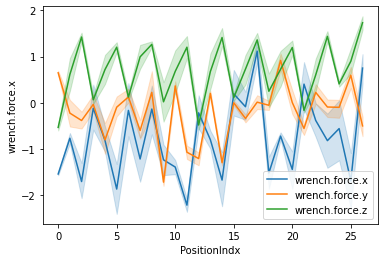

In [38]:
ys = ['wrench.force.x','wrench.force.y','wrench.force.z']
fig, ax = plt.subplots()
for y in ys:
    sns.lineplot(data=all_data,x='PositionIndx', y=y, ax=ax, label=y)
ax.legend()
fig.show()
save_path = os.path.join(save_dir, '{}.png'.format('time_plot_position_indx'))
plt.savefig(save_path)

